# AdaBoost Classification Model (Clean Version)

Ce notebook utilise l'utilitaire DataPreprocessor pour préparer les données et entraîner un modèle AdaBoost pour la classification de signaux de trading crypto.

In [1]:
import sys
import os
# Ajoute le dossier racine du projet au sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root ajouté au sys.path :", project_root)


Project root ajouté au sys.path : c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob


In [2]:
# Imports principaux
import pandas as pd
import numpy as np
from prediction_model.data_preprocess import DataPreprocessor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Chargement des données ETH et XBT
eth_path = "../../data/features/DATA_0/ETH_EUR.parquet"
xbt_path = "../../data/features/DATA_0/XBT_EUR.parquet"
df_eth = pd.read_parquet(eth_path)
df_xbt = pd.read_parquet(xbt_path)
print(f"ETH shape: {df_eth.shape}")
print(f"XBT shape: {df_xbt.shape}")

ETH shape: (1817685, 18)
XBT shape: (563395, 18)


In [4]:
# Initialisation du DataPreprocessor
preprocessor = DataPreprocessor()

# Définition des colonnes features (XBT)
feature_columns = [
    "bid-ask-imbalance-5-levels",
    "spread",
    "inst-return",
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "return-all-signed-for-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'return-all-signed-for-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features...
Features sélectionnées: ['bid-ask-imbalance-5-levels', 'spread', 'inst-return', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 7)
Features shape après dropna: (562683, 7)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 7)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Données après dropna et filtrage NaN: (1817685, 7)
Target après dropna et filtrage NaN: (1817685,)
Distribution des classes:
return-all-signed-for-5-ms
-1     202297
 0    1615386
 1          2
Name: count, dtype: int64
Proportions des classes:
return-all-signed-for-5-ms
-1    0.111294
 0    0.888705
 1    0.000001
Name: proportion, dtype: float64
Étape 5: Conversion en arrays numpy...

=== RÉSULTAT FINAL ===
Features (X): (181768

In [5]:
# Affichage des données avant l'entraînement
print("=== DONNÉES AVANT ENTRAÎNEMENT ===")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_train:\n{X_train[:5]}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_train:\n{y_train[:10]}")
print(f"\nX_test shape: {X_test.shape}")
print(f"X_test:\n{X_test[:5]}")
print(f"\ny_test shape: {y_test.shape}")
print(f"y_test:\n{y_test[:10]}")
print(f"\nDistribution des classes dans y_train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} échantillons ({c/len(y_train)*100:.2f}%)")

=== DONNÉES AVANT ENTRAÎNEMENT ===

X_train shape: (1454148, 7)
X_train:
[[ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]]

y_train shape: (1454148,)
y_train:
[1 1 1 1 1 1 1 1 1 1]

X_test shape: (363537, 7)
X_test:
[[ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.        

In [6]:
# Vérification des NaN dans les données d'entraînement et de test
print("=== VÉRIFICATION DES NaN DANS LES DONNÉES ===")

# Vérification X_train
x_train_nan = np.isnan(X_train)
x_train_has_nan = np.any(x_train_nan)
print(f"\nX_train contient des NaN: {x_train_has_nan}")
if x_train_has_nan:
    nan_indices = np.where(x_train_nan)
    print(f"Nombre total de NaN dans X_train: {np.sum(x_train_nan)}")
    print(f"Lignes avec NaN: {np.unique(nan_indices[0])[:10]}...")  # Affiche les 10 premières
    print(f"Colonnes avec NaN: {np.unique(nan_indices[1])}")

# Vérification X_test
x_test_nan = np.isnan(X_test)
x_test_has_nan = np.any(x_test_nan)
print(f"\nX_test contient des NaN: {x_test_has_nan}")
if x_test_has_nan:
    nan_indices = np.where(x_test_nan)
    print(f"Nombre total de NaN dans X_test: {np.sum(x_test_nan)}")
    print(f"Lignes avec NaN: {np.unique(nan_indices[0])[:10]}...")  # Affiche les 10 premières
    print(f"Colonnes avec NaN: {np.unique(nan_indices[1])}")

# Vérification y_train
y_train_nan = np.isnan(y_train)
y_train_has_nan = np.any(y_train_nan)
print(f"\ny_train contient des NaN: {y_train_has_nan}")
if y_train_has_nan:
    nan_indices = np.where(y_train_nan)[0]
    print(f"Nombre de NaN dans y_train: {np.sum(y_train_nan)}")
    print(f"Indices avec NaN: {nan_indices[:10]}...")  # Affiche les 10 premiers

# Vérification y_test
y_test_nan = np.isnan(y_test)
y_test_has_nan = np.any(y_test_nan)
print(f"\ny_test contient des NaN: {y_test_has_nan}")
if y_test_has_nan:
    nan_indices = np.where(y_test_nan)[0]
    print(f"Nombre de NaN dans y_test: {np.sum(y_test_nan)}")
    print(f"Indices avec NaN: {nan_indices[:10]}...")  # Affiche les 10 premiers

=== VÉRIFICATION DES NaN DANS LES DONNÉES ===

X_train contient des NaN: False

X_test contient des NaN: False

y_train contient des NaN: False

y_test contient des NaN: False

X_train contient des NaN: False

X_test contient des NaN: False

y_train contient des NaN: False

y_test contient des NaN: False


In [7]:
# Calcul des poids pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=unique, y=y_train)
print(f"Class weights: {dict(zip(unique, class_weights))}")

# Création des sample weights
sample_weights = np.array([class_weights[label] for label in y_train])
print(f"Sample weights shape: {sample_weights.shape}")
print(f"Sample weights min/max: {sample_weights.min():.4f}/{sample_weights.max():.4f}")

Class weights: {np.int64(0): np.float64(4.380491625497048), np.int64(1): np.float64(0.5644248265754156)}
Sample weights shape: (1454148,)
Sample weights min/max: 0.5644/4.3805
Sample weights shape: (1454148,)
Sample weights min/max: 0.5644/4.3805


In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialisation du modèle AdaBoost avec sklearn

# Création du modèle AdaBoost avec un arbre de décision comme estimateur de base
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

print("Modèle AdaBoost initialisé avec sklearn")

Modèle AdaBoost initialisé avec sklearn


In [9]:
ada_classifier.fit(X_train, y_train, sample_weight=sample_weights)
print("Modèle AdaBoost entraîné!")

KeyboardInterrupt: 

In [ ]:
# Prédictions et évaluation
y_pred = ada_classifier.predict(X_test)
y_train_pred = ada_classifier.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification report (test):")
print(classification_report(y_test, y_pred))
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_pred))

Train Accuracy: 0.1443
Test Accuracy: 0.1256

Classification report (test):
              precision    recall  f1-score   support

           0       0.10      0.95      0.18     36317
           1       0.85      0.03      0.07    327218
           2       0.00      0.00      0.00         2

    accuracy                           0.13    363537
   macro avg       0.32      0.33      0.08    363537
weighted avg       0.78      0.13      0.08    363537


Confusion matrix (test):
[[ 34367   1950      0]
 [315928  11290      0]
 [     2      0      0]]


c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

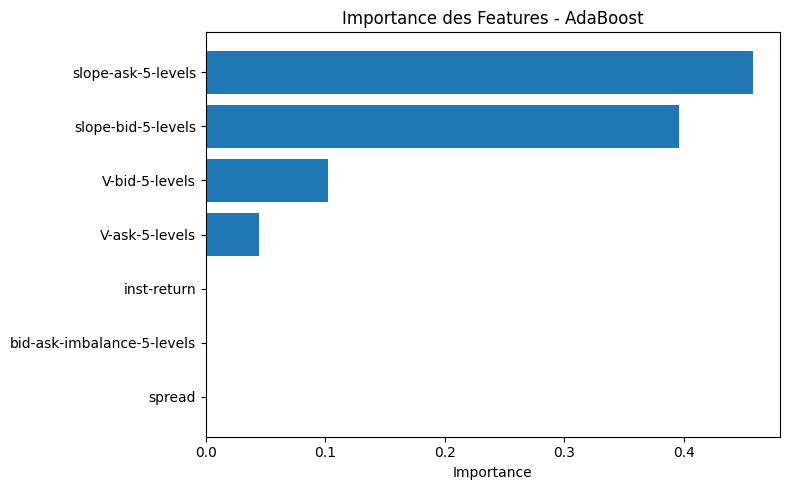

In [ ]:
# Visualisation des importances des features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': ada_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - AdaBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

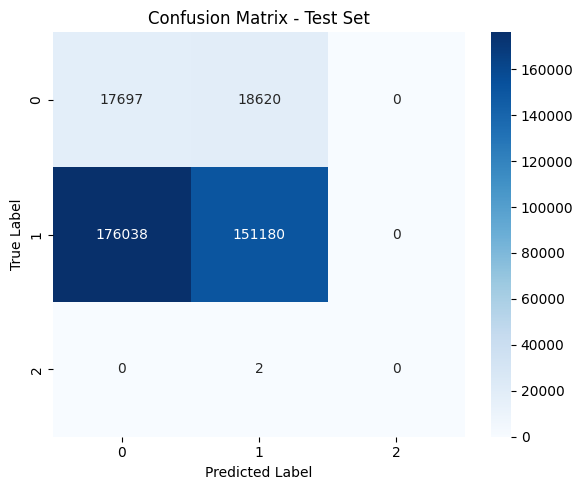

In [ ]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()